In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Dependencies and Setup
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time
import csv
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Import API key
from api_keys import api_key

In [3]:
# Creating DataFrame
tracts_df = pd.read_csv('500_Census_Tracts.csv')

## Selecting a smaller set of variables from the 2016 Census Tracts CDC dataset

In [4]:
tracts_reduced = tracts_df[['StateAbbr', 'PlaceName', 'MHLTH_CrudePrev', 'PHLTH_CrudePrev', 'SLEEP_CrudePrev',
                            'LPA_CrudePrev', 'OBESITY_CrudePrev', 'CSMOKING_CrudePrev', 'BINGE_CrudePrev',
                            'ACCESS2_CrudePrev', 'CHECKUP_CrudePrev', 'DENTAL_CrudePrev', 'COREM_CrudePrev',
                            'COREW_CrudePrev', 'PlaceFIPS', 'TractFIPS', 'Place_TractID', 'Population2010',
                            'Geolocation']]
tracts_reduced.rename(columns = {
    'StateAbbr': 'state',
    'PlaceName': 'city',
    'PlaceFIPS': 'city_FIPS',
    'TractFIPS': 'tract_FIPS',
    'Place_TractID': 'place_tractID',
    'Population2010': 'population_2010',
    'ACCESS2_CrudePrev': 'PS_lack_health_ins',
    'BINGE_CrudePrev': 'UB_binge_drinking',
    'CHECKUP_CrudePrev': 'PS_routine_checkups',
    'COREM_CrudePrev': 'PS_older_men_uptodate',
    'COREW_CrudePrev': 'PS_older_women_uptodate',
    'CSMOKING_CrudePrev': 'UB_current_smoking',
    'DENTAL_CrudePrev': 'PS_dental_checkups',
    'LPA_CrudePrev': 'UB_lack_physical_activity',
    'MHLTH_CrudePrev': 'HO_poor_mental_health',
    'OBESITY_CrudePrev': 'UB_obesity',
    'PHLTH_CrudePrev': 'HO_poor_physical_health',
    'SLEEP_CrudePrev': 'UB_less_sleep',
    'Geolocation': 'geolocation'}, inplace = True)
tracts_reduced.head()

,state,city,HO_poor_mental_health,HO_poor_physical_health,UB_less_sleep,UB_lack_physical_activity,UB_obesity,UB_current_smoking,UB_binge_drinking,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,city_FIPS,tract_FIPS,place_tractID,population_2010,geolocation
0,AL,Birmingham,18.6,20.0,45.5,42.3,47.3,28.5,11.5,23.3,76.6,42.8,29.7,23.2,107000,1073000100,0107000-01073000100,3042,"(33.57943283260, -86.7228323926)"
1,AL,Birmingham,18.4,20.6,44.5,44.6,47.5,28.5,12.0,28.5,73.9,39.7,26.4,20.9,107000,1073000300,0107000-01073000300,2735,"(33.54282086860, -86.7524339780)"
2,AL,Birmingham,17.5,19.3,45.7,42.4,47.2,27.3,11.6,23.9,78.1,44.1,28.0,23.2,107000,1073000400,0107000-01073000400,3338,"(33.56324496330, -86.7640474064)"
3,AL,Birmingham,18.2,21.8,46.1,46.5,49.5,27.9,10.0,25.8,79.5,39.4,24.4,19.8,107000,1073000500,0107000-01073000500,2864,"(33.54424045940, -86.7749130719)"
4,AL,Birmingham,21.1,25.1,48.3,52.4,53.4,31.6,8.4,29.4,79.5,31.4,21.9,16.7,107000,1073000700,0107000-01073000700,2577,"(33.55254061390, -86.8016893706)"


## Aggregating by cities

- Calculating aggregate functions

In [5]:
# Grouping cities
tracts_groups = tracts_reduced.groupby(['city'])

# Calculating mean, median and std for health indicators
cities_HI_mean = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].mean().reset_index()
cities_HI_median = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].median().reset_index()
cities_HI_stdev = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].std().reset_index()

# Calculating min and max for health indicators
cities_HI_min = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].min().reset_index()
cities_HI_max = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].max().reset_index()

# Calculating Q1 and Q3 for health indicators
cities_HI_Q1 = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].apply(lambda x: np.percentile(x,25)).reset_index()
cities_HI_Q3 = tracts_groups['HO_poor_mental_health', 'HO_poor_physical_health', 'UB_binge_drinking', 'UB_current_smoking',
                               'UB_lack_physical_activity', 'UB_obesity', 'UB_less_sleep', 'PS_lack_health_ins',
                              'PS_routine_checkups', 'PS_dental_checkups', 'PS_older_men_uptodate',
                               'PS_older_women_uptodate'].apply(lambda x: np.percentile(x,75)).reset_index()

# Calculating counts of tracts per city
cities_tracts_counts = tracts_groups['tract_FIPS'].count().reset_index()

# Calculating population per city
cities_population_2010 = tracts_groups['population_2010'].sum().reset_index()

In [6]:
# Create master df
df = pd.merge(cities_HI_mean, cities_tracts_counts, on='city')
len(df)

474

In [7]:
df.head()

,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS
0,Abilene,13.608108,13.591892,17.781081,21.421622,28.840541,34.867568,33.440541,23.037838,66.354054,52.024324,31.633333,30.360000,37
1,Akron,15.931818,15.760606,14.895455,26.824242,33.496970,36.575758,43.425758,12.612121,74.539394,52.918182,24.469697,25.065152,66
2,Alameda,9.837500,9.400000,17.537500,11.931250,16.318750,18.675000,33.787500,7.393750,67.525000,71.312500,36.112500,35.043750,16
3,Albany,14.903922,14.158824,15.213725,22.176471,31.519608,35.549020,42.894118,17.603922,76.454902,56.811765,30.594118,27.533333,51
4,Albuquerque,12.455474,12.815328,15.395620,15.774453,18.538686,27.589051,32.128467,11.759124,60.380292,66.245985,40.662044,28.618248,137


## Binning by city size (as measured by tract counts)

In [8]:
df['tract_FIPS'].describe()

count     474.000000
mean       57.405063
std       123.800957
min         8.000000
25%        21.000000
50%        29.000000
75%        52.000000
max      2117.000000
Name: tract_FIPS, dtype: float64

In [10]:
# Calculate quantiles on city size (CS) & prepare bins
bins = [0]
CS_Q1 = int(df['tract_FIPS'].quantile(0.25))
bins.append(CS_Q1)
CS_Q2 = int(df['tract_FIPS'].quantile(0.5))
bins.append(CS_Q2)
CS_Q3 = int(df['tract_FIPS'].quantile(0.75))
bins.append(CS_Q3)
bins.append(2200)
print(bins)
labels = ['Q1', 'Q2', 'Q3', 'Q4']
print(labels)

# Append our bins to df
df['quantile_CS'] = pd.cut(df['tract_FIPS'], bins, labels=labels)
df_sorted = df.sort_values('quantile_CS')
df_sorted.head()

[0, 21, 29, 52, 2200]
['Q1', 'Q2', 'Q3', 'Q4']


,city,HO_poor_mental_health,HO_poor_physical_health,UB_binge_drinking,UB_current_smoking,UB_lack_physical_activity,UB_obesity,UB_less_sleep,PS_lack_health_ins,PS_routine_checkups,PS_dental_checkups,PS_older_men_uptodate,PS_older_women_uptodate,tract_FIPS,quantile_CS
100,Cranston,12.917647,12.476471,16.617647,16.482353,25.547059,25.900000,37.623529,8.688235,82.088235,75.058824,41.358824,33.400000,17,Q1
262,Missoula,11.600000,11.012500,23.181250,18.318750,17.612500,24.962500,27.906250,11.168750,60.968750,63.531250,40.937500,32.175000,16,Q1
103,Danbury,12.420000,11.353333,18.626667,16.233333,21.513333,25.353333,36.100000,11.640000,68.140000,71.333333,32.686667,31.433333,15,Q1
102,Daly City,9.205000,8.895000,13.365000,10.945000,19.980000,18.875000,34.630000,10.385000,65.415000,69.625000,32.820000,33.610000,20,Q1
344,Redlands,11.841176,12.041176,16.935294,13.276471,19.782353,23.929412,35.405882,10.635294,67.317647,66.135294,30.888235,31.300000,17,Q1


## Exploring differences in various health indicators by city size (CS) bins
- There are significant differences in prevalence of poor mental health (see ANOVA test). Tukey's Range test reveals that two pairs (Q1~Q3 and Q1~Q4) are statistically significantly different with respect to prevalence of poor mental health.
- There are significant differences in prevalence of poor physical health (see ANOVA test). Tukey's Range test reveals that only one pair (Q1~Q4) is statistically significantly different with respect to prevalence of poor physical health.
- There is NO significant difference in prevalence of binge drinking by city size (see ANOVA test).
- There are significant differences in prevalence of current smoking (see ANOVA test). Tukey's Range test reveals that three pairs (Q1~Q3, Q1~Q4 and Q2~Q4) are statistically significantly different with respect to prevalence of current smoking.
- There are significant differences in prevalence of lack of physical activity (see ANOVA test). Tukey's Range test reveals that three pairs (Q1~Q3, Q1~Q4 and Q2~Q4) are statistically significantly different with respect to prevalence of lack of physical activity.
- There are significant differences in prevalence of obesity (see ANOVA test). Tukey's Range test reveals that three pairs (Q1~Q3, Q1~Q4 and Q2~Q4) are statistically significantly different with respect to prevalence of obesity.
- There are significant differences in prevalence of lack of sleep (see ANOVA test). Tukey's Range test reveals that four pairs (Q1~Q3, Q1~Q4, Q2~Q3 and Q2~Q4) are statistically significantly different with respect to prevalence of lack of sleep.
- There are significant differences in prevalence of lack of health insurance (see ANOVA test). Tukey's Range test, however, does not reveal any statistically significant pairwise difference with respect to prevalence of lack of health insurance.
- There is NO significant difference in prevalence of routine check-ups by city size (see ANOVA test).
- There are significant differences in prevalence of dental check-ups (see ANOVA test). Tukey's Range test reveals that three pairs (Q1~Q3, Q1~Q4 and Q2~Q4) are statistically significantly different with respect to prevalence of dental check-ups.
- There is NO significant difference in prevalence of older men up to date with clinical preventive services by city size (see ANOVA test).
- There is NO significant difference in prevalence of older women up to date with clinical preventive services by city size (see ANOVA test).

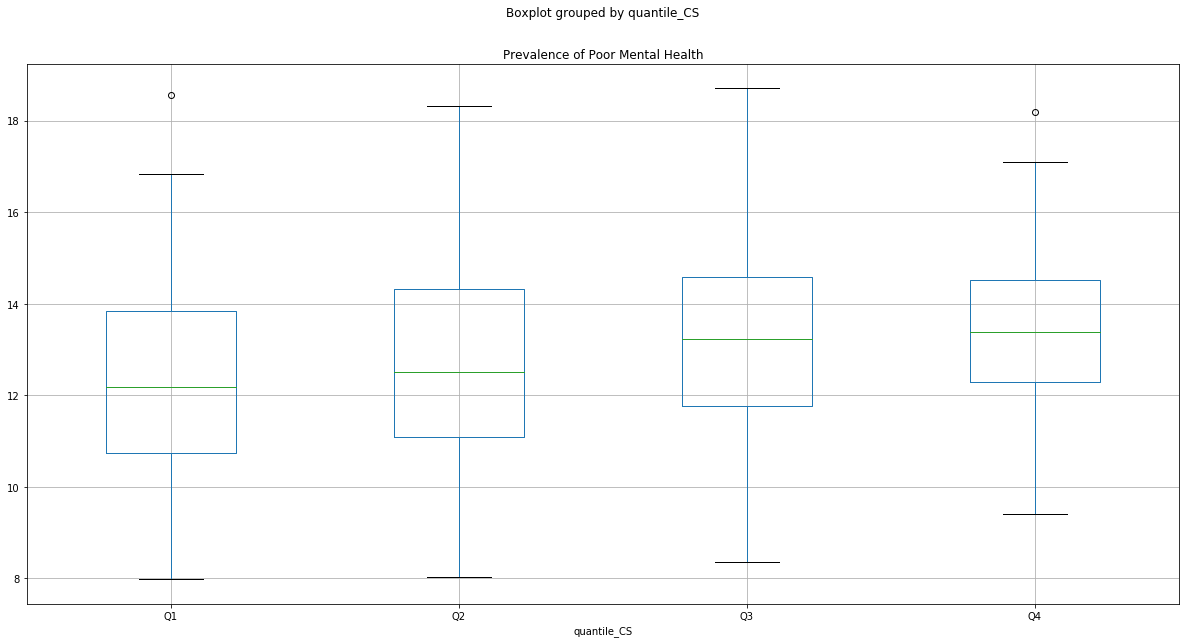

In [14]:
df.boxplot('HO_poor_mental_health', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Poor Mental Health")
plt.show()

In [15]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["HO_poor_mental_health"]
group2 = df[df["quantile_CS"] == 'Q2']["HO_poor_mental_health"]
group3 = df[df["quantile_CS"] == 'Q3']["HO_poor_mental_health"]
group4 = df[df["quantile_CS"] == 'Q4']["HO_poor_mental_health"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=6.521691649292249, pvalue=0.00024985367394803477)

In [16]:
tukey_results_PH = pairwise_tukeyhsd(df_sorted['HO_poor_mental_health'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_PH)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.4271  -0.2539 1.1082 False 
  Q1     Q3    0.8012   0.1138 1.4885  True 
  Q1     Q4    1.0999   0.4219 1.7779  True 
  Q2     Q3    0.374   -0.3298 1.0778 False 
  Q2     Q4    0.6727  -0.0219 1.3673 False 
  Q3     Q4    0.2987  -0.4021 0.9995 False 
--------------------------------------------


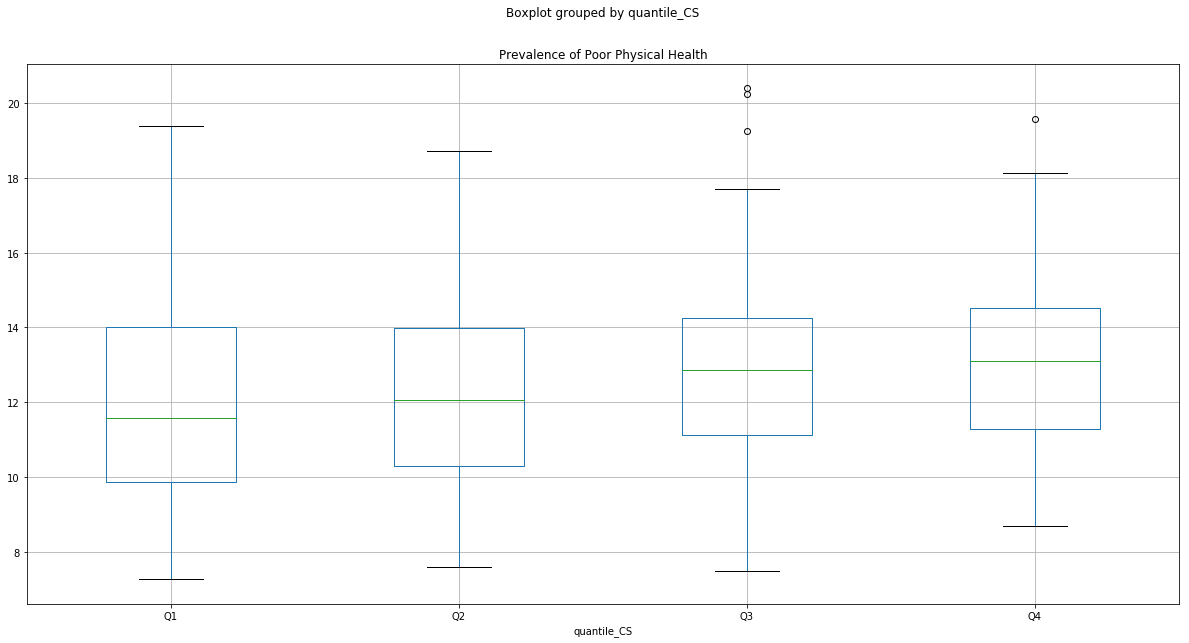

In [11]:
df.boxplot('HO_poor_physical_health', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Poor Physical Health")
plt.show()

In [12]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["HO_poor_physical_health"]
group2 = df[df["quantile_CS"] == 'Q2']["HO_poor_physical_health"]
group3 = df[df["quantile_CS"] == 'Q3']["HO_poor_physical_health"]
group4 = df[df["quantile_CS"] == 'Q4']["HO_poor_physical_health"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=4.5213473876361245, pvalue=0.0038717154549686187)

In [13]:
tukey_results_PH = pairwise_tukeyhsd(df_sorted['HO_poor_physical_health'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_PH)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.351   -0.4738 1.1759 False 
  Q1     Q3    0.8209  -0.0116 1.6535 False 
  Q1     Q4    1.0784   0.2573 1.8996  True 
  Q2     Q3    0.4699  -0.3825 1.3223 False 
  Q2     Q4    0.7274  -0.1139 1.5687 False 
  Q3     Q4    0.2575  -0.5913 1.1064 False 
--------------------------------------------


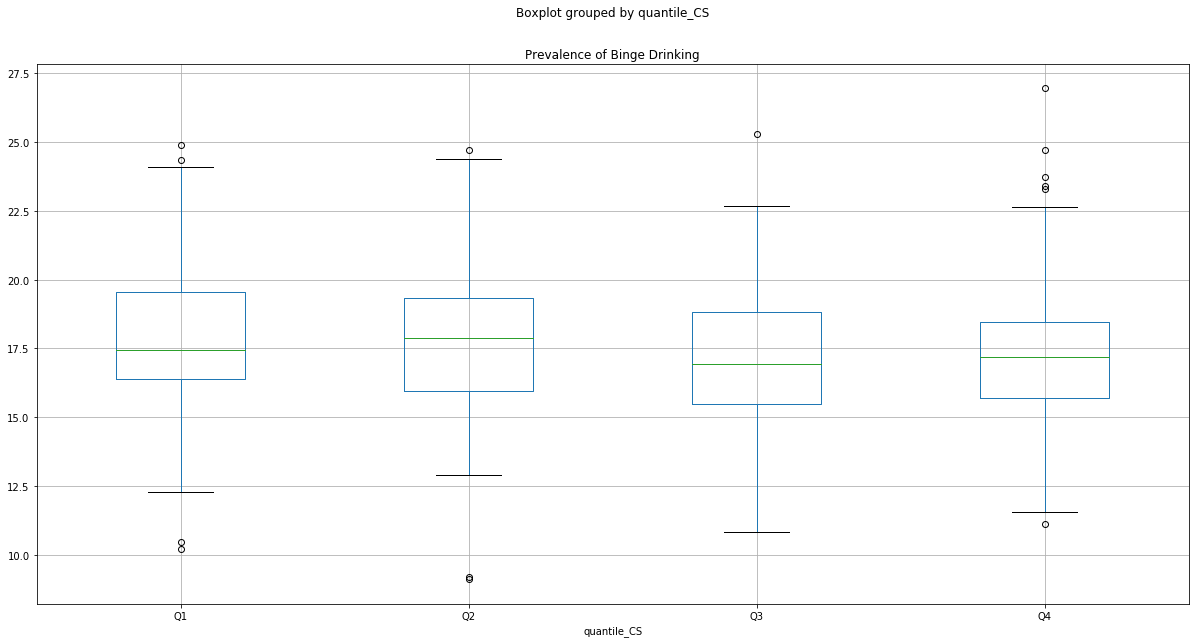

In [17]:
df.boxplot('UB_binge_drinking', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Binge Drinking")
plt.show()

In [18]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["UB_binge_drinking"]
group2 = df[df["quantile_CS"] == 'Q2']["UB_binge_drinking"]
group3 = df[df["quantile_CS"] == 'Q3']["UB_binge_drinking"]
group4 = df[df["quantile_CS"] == 'Q4']["UB_binge_drinking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=1.2629454045519788, pvalue=0.2864960084833913)

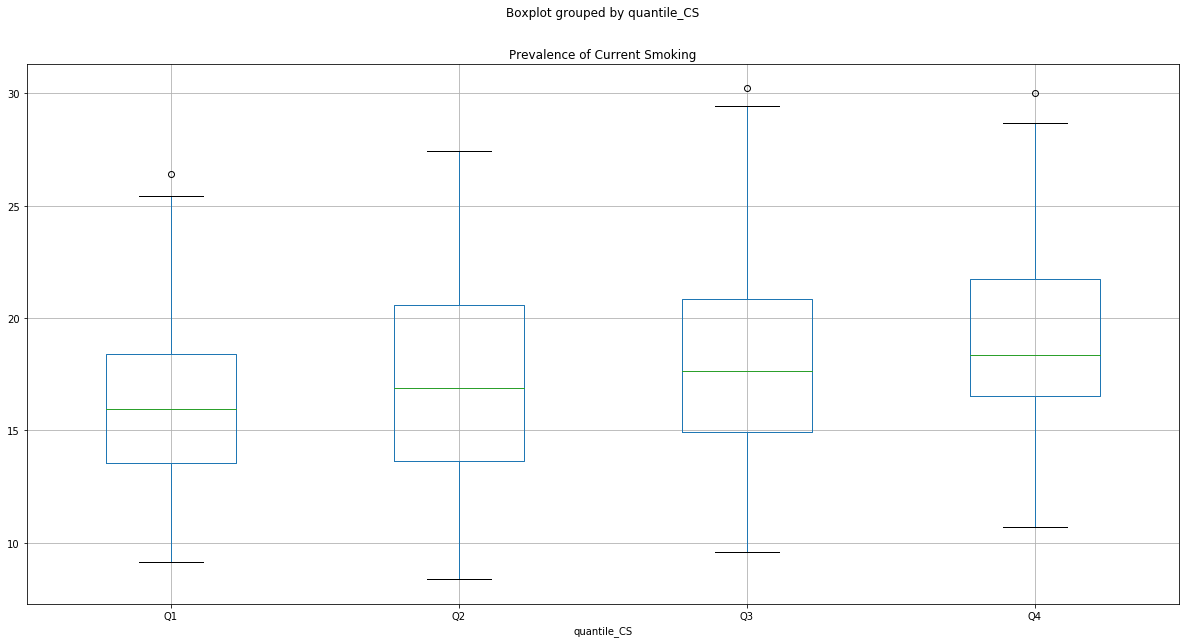

In [19]:
df.boxplot('UB_current_smoking', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Current Smoking")
plt.show()

In [20]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["UB_current_smoking"]
group2 = df[df["quantile_CS"] == 'Q2']["UB_current_smoking"]
group3 = df[df["quantile_CS"] == 'Q3']["UB_current_smoking"]
group4 = df[df["quantile_CS"] == 'Q4']["UB_current_smoking"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=11.72262074368769, pvalue=2.0298025418810487e-07)

In [21]:
tukey_results_UBcs = pairwise_tukeyhsd(df_sorted['UB_current_smoking'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_UBcs)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    1.0744  -0.2797 2.4285 False 
  Q1     Q3    1.9145   0.5478 3.2812  True 
  Q1     Q4    2.9923   1.6442 4.3403  True 
  Q2     Q3    0.8401  -0.5592 2.2394 False 
  Q2     Q4    1.9178   0.5367 3.2989  True 
  Q3     Q4    1.0777  -0.3158 2.4712 False 
--------------------------------------------


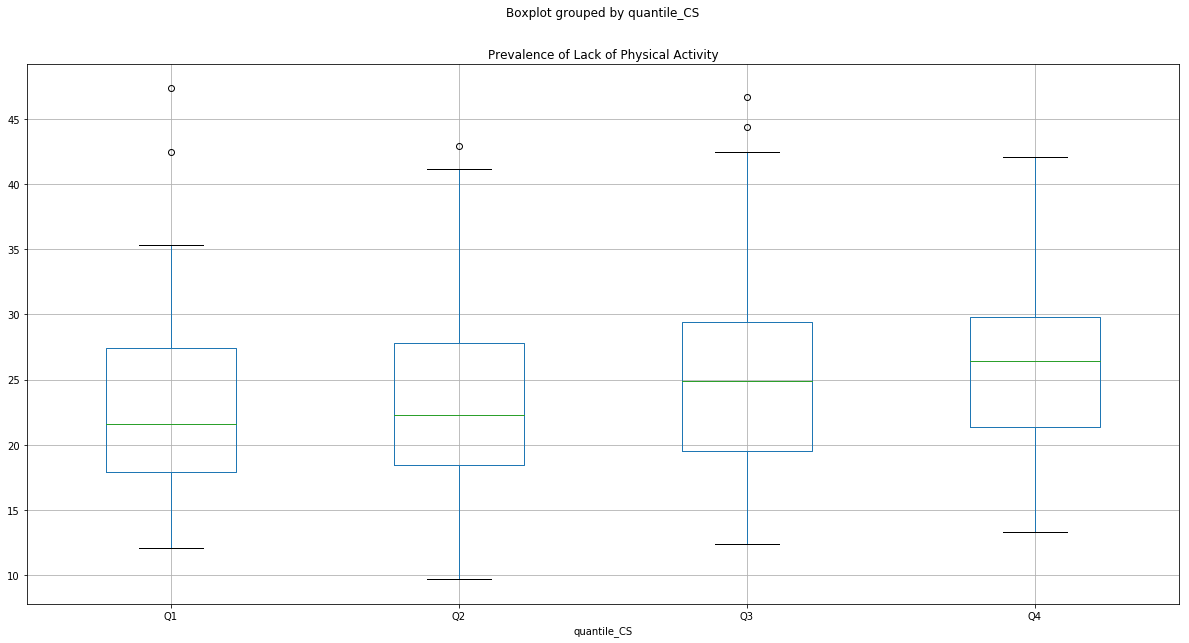

In [22]:
df.boxplot('UB_lack_physical_activity', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Lack of Physical Activity")
plt.show()

In [23]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["UB_lack_physical_activity"]
group2 = df[df["quantile_CS"] == 'Q2']["UB_lack_physical_activity"]
group3 = df[df["quantile_CS"] == 'Q3']["UB_lack_physical_activity"]
group4 = df[df["quantile_CS"] == 'Q4']["UB_lack_physical_activity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=6.217792278022568, pvalue=0.00037923435274817116)

In [24]:
tukey_results_UBpa = pairwise_tukeyhsd(df_sorted['UB_lack_physical_activity'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_UBpa)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.6865   -1.463 2.8361 False 
  Q1     Q3    2.3938   0.2243 4.5634  True 
  Q1     Q4    3.185    1.0451 5.325   True 
  Q2     Q3    1.7073   -0.514 3.9286 False 
  Q2     Q4    2.4985   0.3061 4.6909  True 
  Q3     Q4    0.7912  -1.4208 3.0033 False 
--------------------------------------------


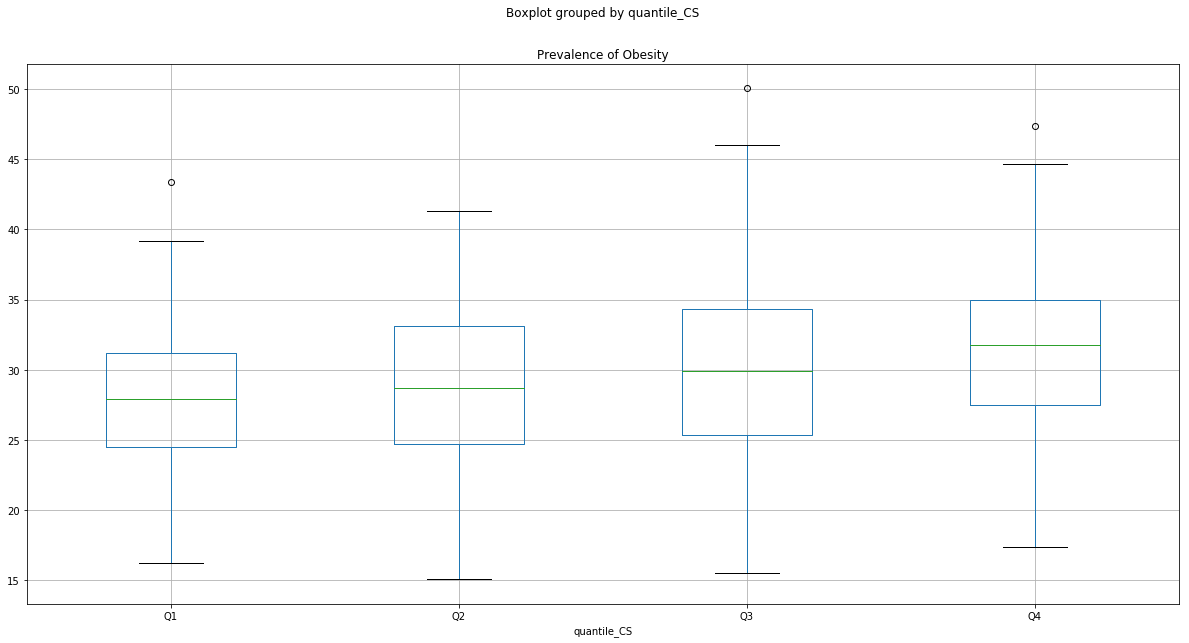

In [25]:
df.boxplot('UB_obesity', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Obesity")
plt.show()

In [26]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["UB_obesity"]
group2 = df[df["quantile_CS"] == 'Q2']["UB_obesity"]
group3 = df[df["quantile_CS"] == 'Q3']["UB_obesity"]
group4 = df[df["quantile_CS"] == 'Q4']["UB_obesity"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=9.313120031045374, pvalue=5.425711330258717e-06)

In [27]:
tukey_results_UBo = pairwise_tukeyhsd(df_sorted['UB_obesity'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_UBo)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    1.2955  -0.6071 3.198  False 
  Q1     Q3    2.4161   0.4958 4.3364  True 
  Q1     Q4    3.7291   1.835  5.6232  True 
  Q2     Q3    1.1207  -0.8454 3.0868 False 
  Q2     Q4    2.4336   0.4931 4.3741  True 
  Q3     Q4    1.3129  -0.6449 3.2708 False 
--------------------------------------------


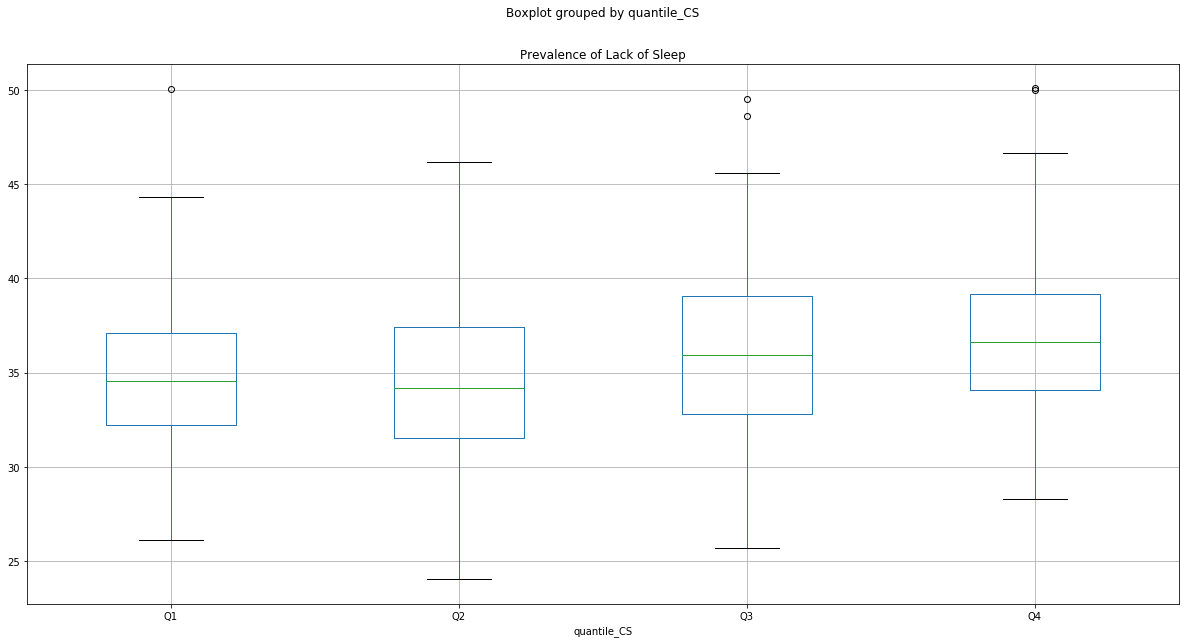

In [28]:
df.boxplot('UB_less_sleep', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Lack of Sleep")
plt.show()

In [29]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["UB_less_sleep"]
group2 = df[df["quantile_CS"] == 'Q2']["UB_less_sleep"]
group3 = df[df["quantile_CS"] == 'Q3']["UB_less_sleep"]
group4 = df[df["quantile_CS"] == 'Q4']["UB_less_sleep"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=6.985331823625077, pvalue=0.00013217314965151378)

In [30]:
tukey_results_UBls = pairwise_tukeyhsd(df_sorted['UB_less_sleep'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_UBls)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2    0.0029  -1.4119 1.4176 False 
  Q1     Q3    1.4711   0.0432 2.8991  True 
  Q1     Q4    2.0326   0.6242 3.4411  True 
  Q2     Q3    1.4683   0.0062 2.9303  True 
  Q2     Q4    2.0298   0.5868 3.4727  True 
  Q3     Q4    0.5615  -0.8944 2.0174 False 
--------------------------------------------


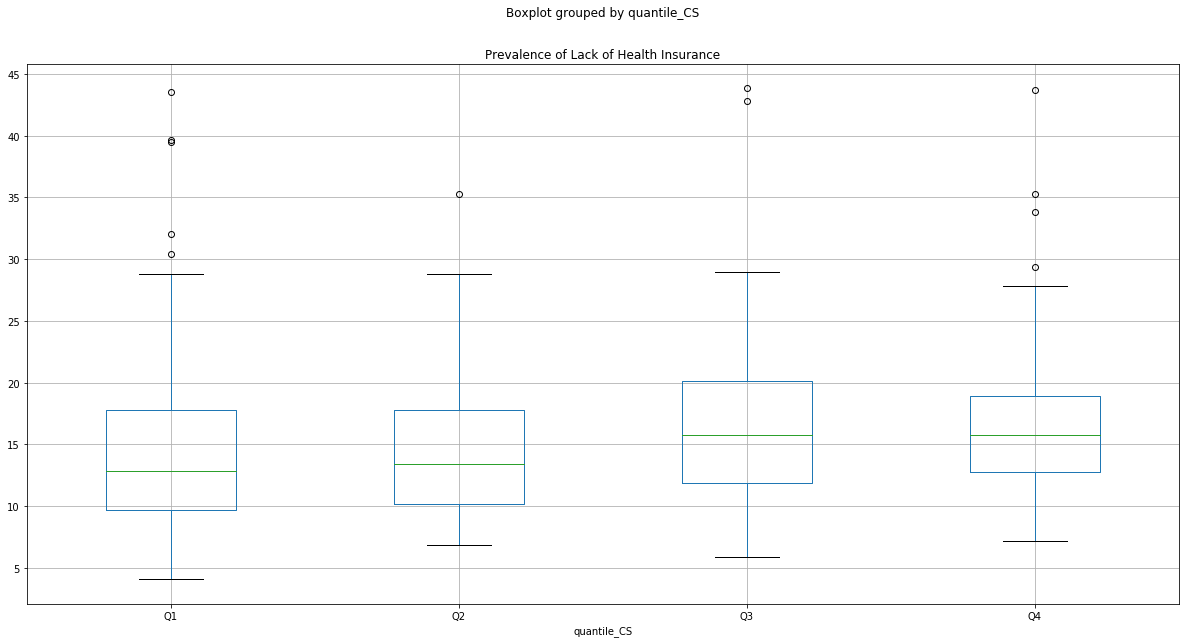

In [31]:
df.boxplot('PS_lack_health_ins', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Lack of Health Insurance")
plt.show()

In [32]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["PS_lack_health_ins"]
group2 = df[df["quantile_CS"] == 'Q2']["PS_lack_health_ins"]
group3 = df[df["quantile_CS"] == 'Q3']["PS_lack_health_ins"]
group4 = df[df["quantile_CS"] == 'Q4']["PS_lack_health_ins"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=3.1013487214139928, pvalue=0.026469158579423776)

In [33]:
tukey_results_PShi = pairwise_tukeyhsd(df_sorted['PS_lack_health_ins'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_PShi)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower  upper  reject
--------------------------------------------
  Q1     Q2   -0.0635   -2.157  2.03  False 
  Q1     Q3    1.6215  -0.4915 3.7345 False 
  Q1     Q4    1.8482   -0.236 3.9324 False 
  Q2     Q3    1.6849  -0.4785 3.8483 False 
  Q2     Q4    1.9117  -0.2236 4.0469 False 
  Q3     Q4    0.2267  -1.9277 2.3811 False 
--------------------------------------------


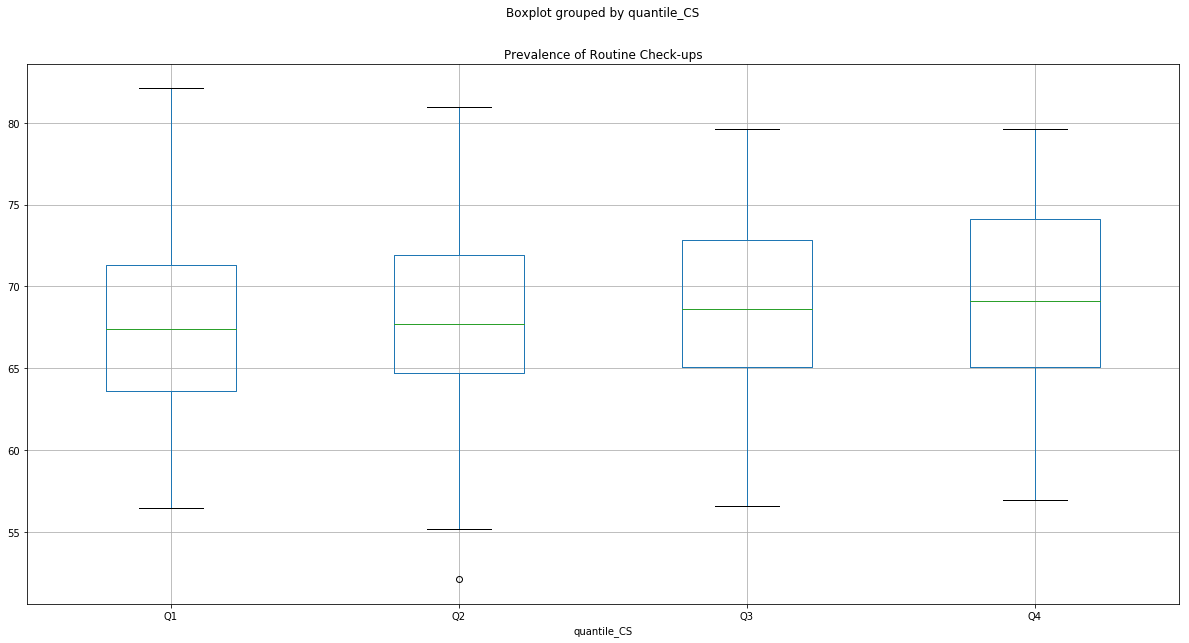

In [34]:
df.boxplot('PS_routine_checkups', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Routine Check-ups")
plt.show()

In [35]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["PS_routine_checkups"]
group2 = df[df["quantile_CS"] == 'Q2']["PS_routine_checkups"]
group3 = df[df["quantile_CS"] == 'Q3']["PS_routine_checkups"]
group4 = df[df["quantile_CS"] == 'Q4']["PS_routine_checkups"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=2.2614771272244614, pvalue=0.0805534440918015)

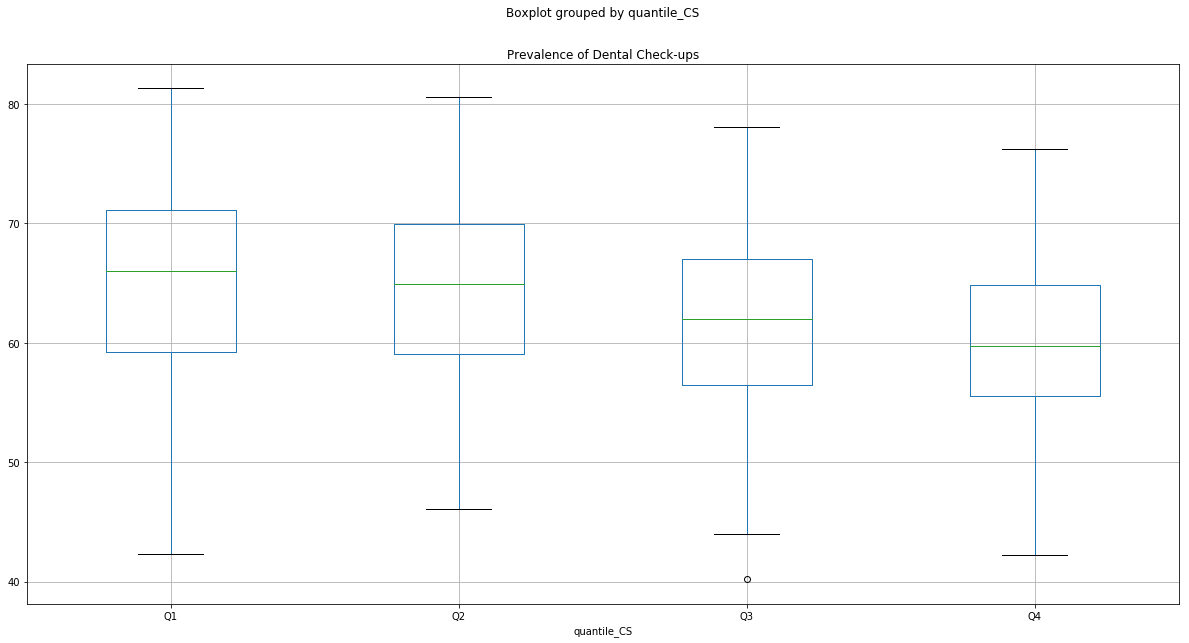

In [36]:
df.boxplot('PS_dental_checkups', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Dental Check-ups")
plt.show()

In [37]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["PS_dental_checkups"]
group2 = df[df["quantile_CS"] == 'Q2']["PS_dental_checkups"]
group3 = df[df["quantile_CS"] == 'Q3']["PS_dental_checkups"]
group4 = df[df["quantile_CS"] == 'Q4']["PS_dental_checkups"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=9.607720818373567, pvalue=3.625908346547131e-06)

In [38]:
tukey_results_PSdc = pairwise_tukeyhsd(df_sorted['PS_dental_checkups'], df_sorted['quantile_CS'], 0.05)
print(tukey_results_PSdc)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower   upper  reject
---------------------------------------------
  Q1     Q2   -0.2448  -2.7725  2.2829 False 
  Q1     Q3    -2.695  -5.2462 -0.1437  True 
  Q1     Q4   -4.5637  -7.0801 -2.0473  True 
  Q2     Q3   -2.4502  -5.0623  0.1619 False 
  Q2     Q4   -4.3189   -6.897 -1.7408  True 
  Q3     Q4   -1.8687  -4.4699  0.7325 False 
---------------------------------------------


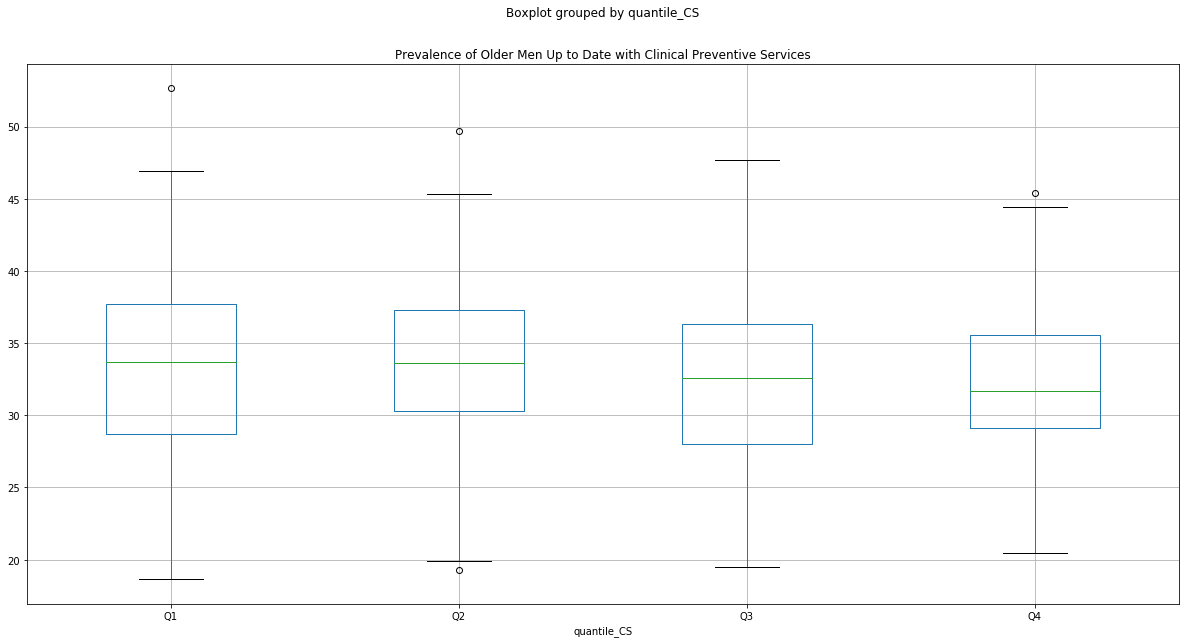

In [39]:
df.boxplot('PS_older_men_uptodate', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Older Men Up to Date with Clinical Preventive Services")
plt.show()

In [40]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["PS_older_men_uptodate"]
group2 = df[df["quantile_CS"] == 'Q2']["PS_older_men_uptodate"]
group3 = df[df["quantile_CS"] == 'Q3']["PS_older_men_uptodate"]
group4 = df[df["quantile_CS"] == 'Q4']["PS_older_men_uptodate"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=2.0916545202234658, pvalue=0.10049721848497191)

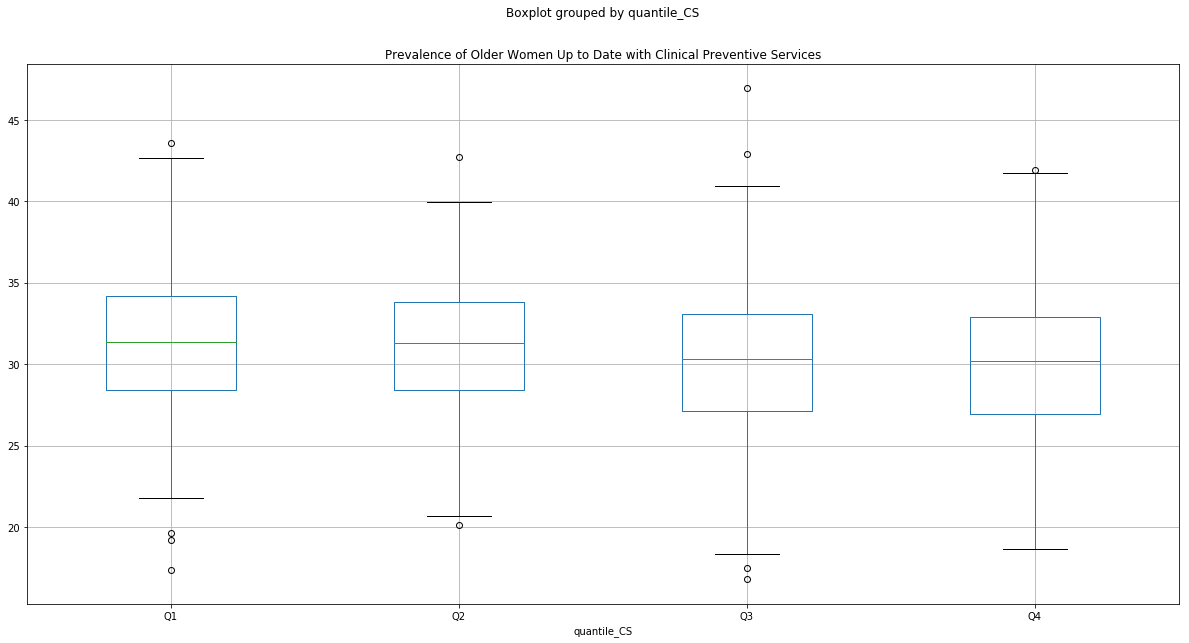

In [41]:
df.boxplot('PS_older_women_uptodate', by='quantile_CS', figsize=(20, 10))
plt.title("Prevalence of Older Women Up to Date with Clinical Preventive Services")
plt.show()

In [42]:
# Extract individual groups
group1 = df[df["quantile_CS"] == 'Q1']["PS_older_women_uptodate"]
group2 = df[df["quantile_CS"] == 'Q2']["PS_older_women_uptodate"]
group3 = df[df["quantile_CS"] == 'Q3']["PS_older_women_uptodate"]
group4 = df[df["quantile_CS"] == 'Q4']["PS_older_women_uptodate"]

# Perform the ANOVA
stats.f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=1.5311428657093111, pvalue=0.20561216920427536)